In [76]:
import sys
import subprocess
packages = ['torch', 'numpy', 'matplotlib', 'pillow', 'scikit-learn', 'pandas', 'torchvision']
for package in packages:
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
        print(f"✓ {package} installed")
    except Exception as e:
        print(f"✗ {package} failed: {e}")

✓ torch installed
✓ numpy installed
✓ matplotlib installed
✓ pillow installed
✓ scikit-learn installed
✓ pandas installed
✓ torchvision installed


In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
import os

print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")

PyTorch version: 2.9.1
MPS available: True


In [78]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

model = SRCNN()
print("SRCNN Parameters (as specified):")
print("Conv1: 3 x 9 x 9, 64 filters")
print("Conv2: 64 x 1 x 1, 32 filters")
print("Conv3: 32 x 5 x 5, 3 filters")
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

SRCNN Parameters (as specified):
Conv1: 3 x 9 x 9, 64 filters
Conv2: 64 x 1 x 1, 32 filters
Conv3: 32 x 5 x 5, 3 filters

Total parameters: 20099


Training images: (5000, 32, 32, 3)


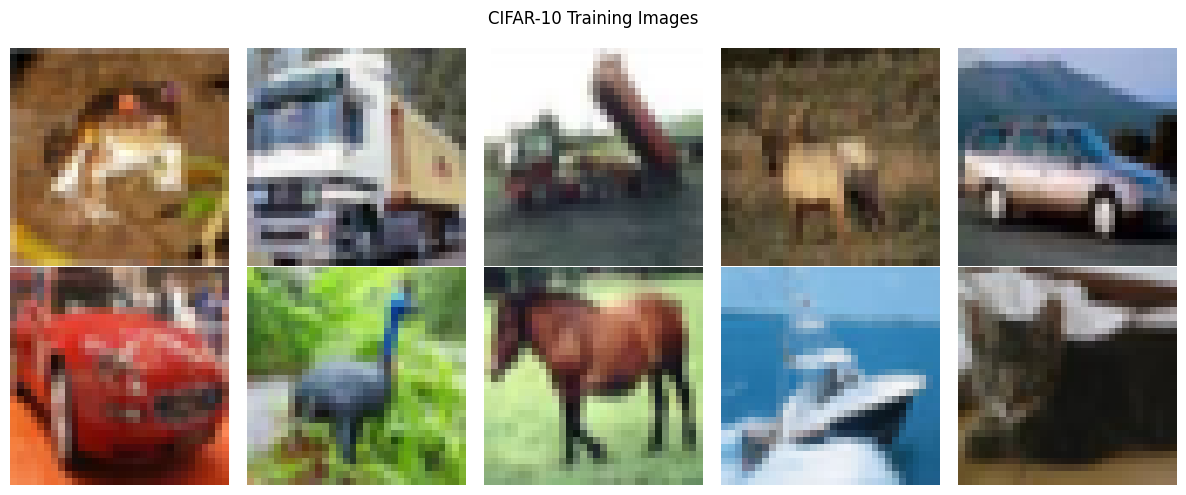

In [79]:
import torchvision
import torchvision.transforms as transforms

cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

train_images = []
for i in range(5000):
    img, _ = cifar_dataset[i]
    train_images.append(img.permute(1, 2, 0).numpy())

train_images = np.array(train_images)
print(f"Training images: {train_images.shape}")

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(train_images[i])
    ax.axis('off')
plt.suptitle('CIFAR-10 Training Images')
plt.tight_layout()
plt.show()

Training pairs: 5000


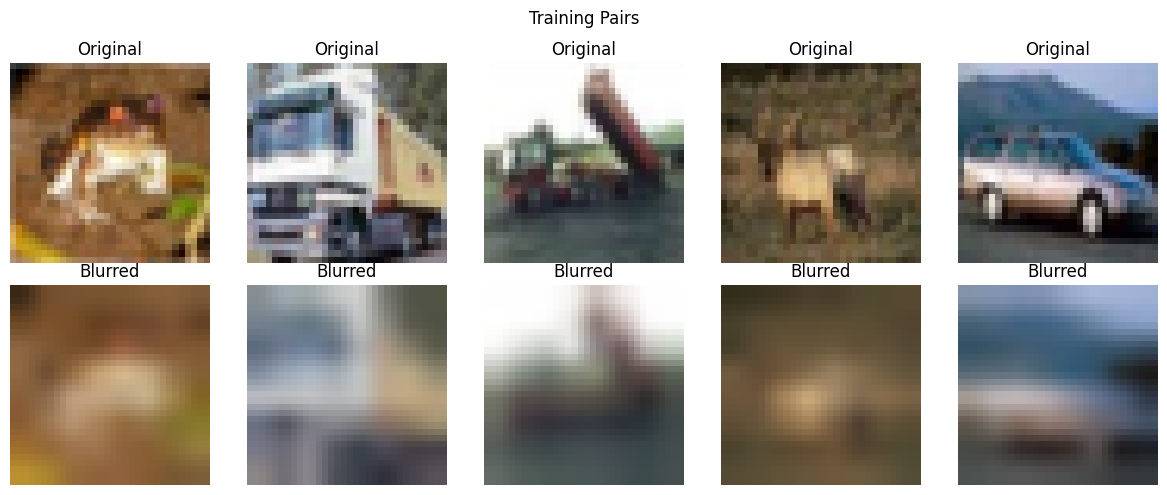

In [80]:
def create_blurred_image(image, scale_factor=4):
    width, height = image.size
    small = image.resize((width // scale_factor, height // scale_factor), Image.BILINEAR)
    blurred = small.resize((width, height), Image.BILINEAR)
    return blurred

def create_blurred_array_rgb(img, scale_factor=4):
    h, w = img.shape[:2]
    img_pil = Image.fromarray((img * 255).astype(np.uint8))
    small = img_pil.resize((w // scale_factor, h // scale_factor), Image.BILINEAR)
    blurred = small.resize((w, h), Image.BILINEAR)
    return np.array(blurred).astype(np.float32) / 255.0

def psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def image_to_tensor(image):
    img_array = np.array(image).astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).unsqueeze(0)
    return img_tensor

def tensor_to_image(tensor):
    img_array = tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
    img_array = np.clip(img_array, 0, 1)
    return img_array

train_original = []
train_blurred = []

for img in train_images:
    blurred = create_blurred_array_rgb(img, scale_factor=4)
    
    orig_tensor = torch.from_numpy(img).permute(2, 0, 1)
    blur_tensor = torch.from_numpy(blurred).permute(2, 0, 1)
    
    train_original.append(orig_tensor)
    train_blurred.append(blur_tensor)

print(f"Training pairs: {len(train_original)}")

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(5):
    axes[0, i].imshow(train_original[i].permute(1, 2, 0).numpy())
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    axes[1, i].imshow(train_blurred[i].permute(1, 2, 0).numpy())
    axes[1, i].set_title('Blurred')
    axes[1, i].axis('off')
plt.suptitle('Training Pairs')
plt.tight_layout()
plt.show()

In [81]:
from torch.utils.data import Dataset, DataLoader

class DeblurDataset(Dataset):
    def __init__(self, blurred, original):
        self.blurred = blurred
        self.original = original
    
    def __len__(self):
        return len(self.blurred)
    
    def __getitem__(self, idx):
        return self.blurred[idx], self.original[idx]

train_dataset = DeblurDataset(train_blurred, train_original)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = SRCNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

Epoch 25/100, Loss: 0.008364
Epoch 50/100, Loss: 0.008051
Epoch 75/100, Loss: 0.008002
Epoch 100/100, Loss: 0.007827


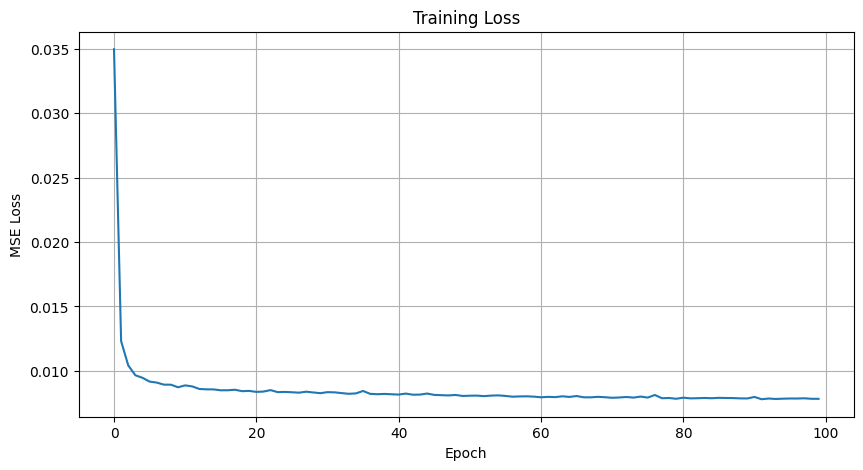

In [82]:
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for blurred, original in train_loader:
        optimizer.zero_grad()
        output = model(blurred)
        loss = criterion(output, original)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    
    if (epoch + 1) % 25 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}')

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

In [83]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

test_img, test_label = test_dataset[0]
original_array = test_img.permute(1, 2, 0).numpy()

blurred_array = create_blurred_array_rgb(original_array, scale_factor=4)

orig_tensor = torch.from_numpy(original_array).permute(2, 0, 1).unsqueeze(0)
blur_tensor = torch.from_numpy(blurred_array).permute(2, 0, 1).unsqueeze(0)

model.eval()
with torch.no_grad():
    output_tensor = model(blur_tensor)

output_array = output_tensor.squeeze(0).permute(1, 2, 0).numpy()
output_array = np.clip(output_array, 0, 1)

psnr_blurred = psnr(original_array, blurred_array)
psnr_output = psnr(original_array, output_array)

print(f"PSNR Blurred: {psnr_blurred:.2f} dB")
print(f"PSNR Deblurred: {psnr_output:.2f} dB")
print(f"Improvement: {psnr_output - psnr_blurred:.2f} dB")

PSNR Blurred: 19.60 dB
PSNR Deblurred: 20.71 dB
Improvement: 1.10 dB


In [84]:
test_results = []
for i in range(5):
    test_img, _ = test_dataset[i]
    orig = test_img.permute(1, 2, 0).numpy()
    blur = create_blurred_array_rgb(orig, scale_factor=4)
    
    blur_t = torch.from_numpy(blur).permute(2, 0, 1).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        out_t = model(blur_t)
    out = np.clip(out_t.squeeze(0).permute(1, 2, 0).numpy(), 0, 1)
    
    p_blur = psnr(orig, blur)
    p_out = psnr(orig, out)
    test_results.append({'Image': i+1, 'Blurred': f'{p_blur:.2f}', 'Deblurred': f'{p_out:.2f}', 'Improvement': f'{p_out-p_blur:.2f}'})

print(pd.DataFrame(test_results).to_string(index=False))
print(f"\nAverage Improvement: {np.mean([float(r['Improvement']) for r in test_results]):.2f} dB")

 Image Blurred Deblurred Improvement
     1   19.60     20.71        1.10
     2   18.97     20.47        1.50
     3   21.77     23.20        1.43
     4   19.71     20.87        1.16
     5   20.01     20.99        0.99

Average Improvement: 1.24 dB
